## Objectives:

To implement an exponential model for CoVid-19 confirmed cases for every country.
The model may be implemented in three ways:
1. Unpooled (with different priors for each country)
2. Pooled (with same priors for each country)
3. Hierarchical (with same hyper-priors, but different priors for each country)

This notebook shows all three implementations using pyMC3 and their analysis.


A justification for using an exponential model is provided in the `Rationale` section.

Inspired from [Thomas Wiecki's CoVid-19](https://github.com/twiecki/covid19) notebooks.

**Note**: The notebook uses the `interact` widget. Please fork it and view in editor to interact with the output.

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path

import pymc as pm
import arviz as az

import cufflinks as cf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error
from ipywidgets import interact, interact_manual, fixed

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('use_inf_as_na', True)
cf.set_config_file(offline=True, theme='pearl');
path = Path("data/")

/var/folders/5x/vz4_nh_d6f5ds1c71xs4q_n0qqgwj_/T/ipykernel_65526/2430209213.py:2: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



In [3]:
master_df = pd.read_csv(path/'covid_19_data.csv')

In [4]:
recovered_df = (pd.read_csv(path/'time_series_covid_19_recovered.csv')
                .drop(columns=['Lat', 'Long', 'Province/State'])
                .groupby('Country/Region')
                .sum())

deaths_df = (pd.read_csv(path/'time_series_covid_19_deaths.csv')
             .drop(columns=['Lat', 'Long', 'Province/State'])
             .groupby('Country/Region')
             .sum())

confirmed_df = (pd.read_csv(path/'time_series_covid_19_confirmed.csv')
                .drop(columns=['Lat', 'Long', 'Province/State'])
                .groupby('Country/Region')
                .sum())

In [5]:
confirmed_df.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  ...  5/20/21  5/21/21  5/22/21  \
Country/Region                             ...                              
Afghanistan           0        0        0  ...    64575    65080    65486   
Albania               0        0        0  ...   132118   132153   132176   
Algeria               0        0        0  ...   126156   126434   126651   
Andorra               0        0        0  ...    13569    13569    13569   
Angola                0        0        0  ...    31661    31909    32149   

                5/23/21  5/24/21  5/25/21  5/26/21  5/27/21  5/28/21  5/29/21  
Country/Region                                                                 
Afghanistan       65728    66275    66903    67743    68366    69130    70111  
Albania          132209   132215   132229   132244   132264   132285   132297  
Algeria          126860   127107   127361   127646   127926   128198   128456  
Andorra           13569    13569    13664    13671    13682    13693    13693  
Angola            32441    32623    32933    33338    33607    33944    34180  

[5 rows x 494 columns]

## Rationale

An exponential model is given by:

$ y' = y_{0} * (1 + b)^x $

where, $b$ is the growth rate

By taking a logarithmic transform, we obtain a (log-linear) regression model

$ \implies ln(y') = ln(y_{0}) + x*ln(1 + b)$

$\implies y = \alpha + \beta * x$

Graphically, we can validate that a distribution follows a exponential growth model by plotting $ln(y)$ against $x$.
If the graph shows a linear relationship, we can solve for $\alpha$ and $\beta$ using linear regression techniques. 

Values for $a$ and $b$ can be obtained by:
* $ y_{0} = e^{\alpha}$
* $ b = e^{\beta} - 1$

In [6]:
# sorted_country_list = confirmed_df.sort_values(by=confirmed_df.columns[-1], ascending=False).index.to_list()
sorted_country_list = confirmed_df.index

In [7]:
@interact(country=sorted_country_list, threshold=(1, 1000, 10), fit=True)
def log_lin_visualise(country, fit, threshold=100):
    
    y = confirmed_df.filter(items=[country], axis=0).values.squeeze(0).astype(float)
    y = np.log(y[y > threshold])
    x = np.arange(1, y.shape[0] + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Observed')
    
    if fit:

        lr = LinearRegression()
        lr.fit(X=x.reshape(-1, 1) , y=y)
        α, β =  lr.intercept_, lr.coef_

        y_fitted = lr.predict(X=x.reshape(-1, 1))

        print("Solving linear regression using OLS ... ")
        print(f"* r2_score = {round(r2_score(y, y_fitted), 2)}")
        print(f"* mean_squared_error = {round(mean_squared_error(y, y_fitted), 2)}")

        plt.plot(x, y_fitted, label=f"{round(α, 2)} + {round(β[0], 2)}*x")

    plt.xlabel(f'Days Since {threshold}th Case')
    plt.ylabel('Natural Logarithm of Confirmed Cases')
    plt.legend()
    plt.title(country)
    plt.show()
    plt.close()

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

#### Observation

We can clearly observe a linear relationship between $ln(y)$ and $x$ for highly infected countries (except China and S. Korea)

## Model

### Unpooled Model

Different priors for every country. 

This model needs to be run separately for each country.

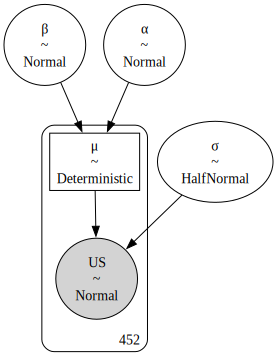

In [8]:
country = 'US'
threshold = 100

y = confirmed_df.filter(items=[country], axis=0).values.squeeze(0)
y = np.log(y[y > threshold])
x = np.arange(1, y.shape[0] + 1)


with pm.Model() as unpooled_model:
    
    
    # priors
    α = pm.Normal(name='α', mu=int(np.log(threshold)), sigma=10)
    β = pm.Normal(name='β')
    
    # error
    σ = pm.HalfNormal(name='σ', sigma=10)
    
    # expected value
    μ = pm.Deterministic(name='μ', var= α + β*x)
    
    # liklihood == 'prior_predictive'
    pm.Normal(name=country, mu=μ, sigma=σ, observed=y)
    
gv = pm.model_to_graphviz(unpooled_model)
gv.format = 'png'
gv.render(filename='unpooled_model.png')
gv

In [9]:
with unpooled_model:
    
    # sampling liklihood
    prior = pm.sample_prior_predictive()
    
    # posterior
    trace = pm.sample()
    
    # predictions == 'posterior_predictive'
    pred = pm.sample_posterior_predictive(trace)

Sampling: [US, α, β, σ]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [US]


Output()

In [10]:
def custom_from_pymc3(trace, prior, pred):
    unpooled = az.convert_to_inference_data(trace)
    unpooled.extend(pred)
    unpooled.extend(prior)
    return unpooled

In [11]:
# unpooled = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=pred, model=unpooled_model)
unpooled = custom_from_pymc3(trace, prior, pred)
prior_vars = ['α', 'β', 'σ']
unpooled

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [12]:
unpooled.posterior['α'].shape

(4, 1000)

In [13]:
summary_df = az.summary(unpooled)
summary_df.to_csv(f'unpooled_{country}_summary.csv')

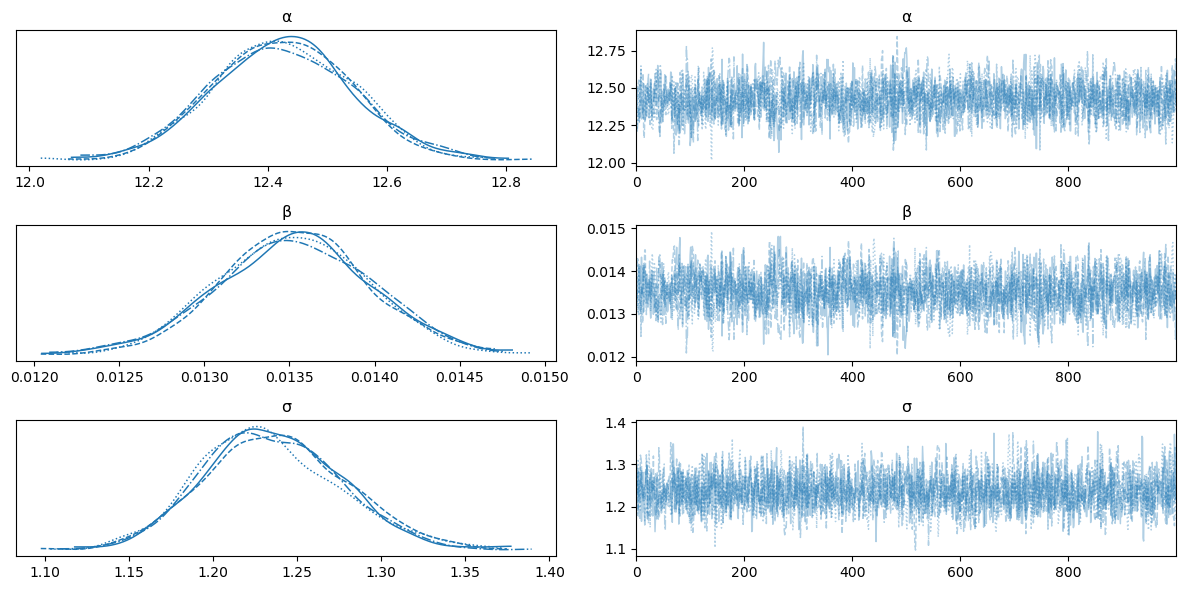

In [14]:
az.plot_trace(data=unpooled, var_names=prior_vars);
plt.tight_layout()

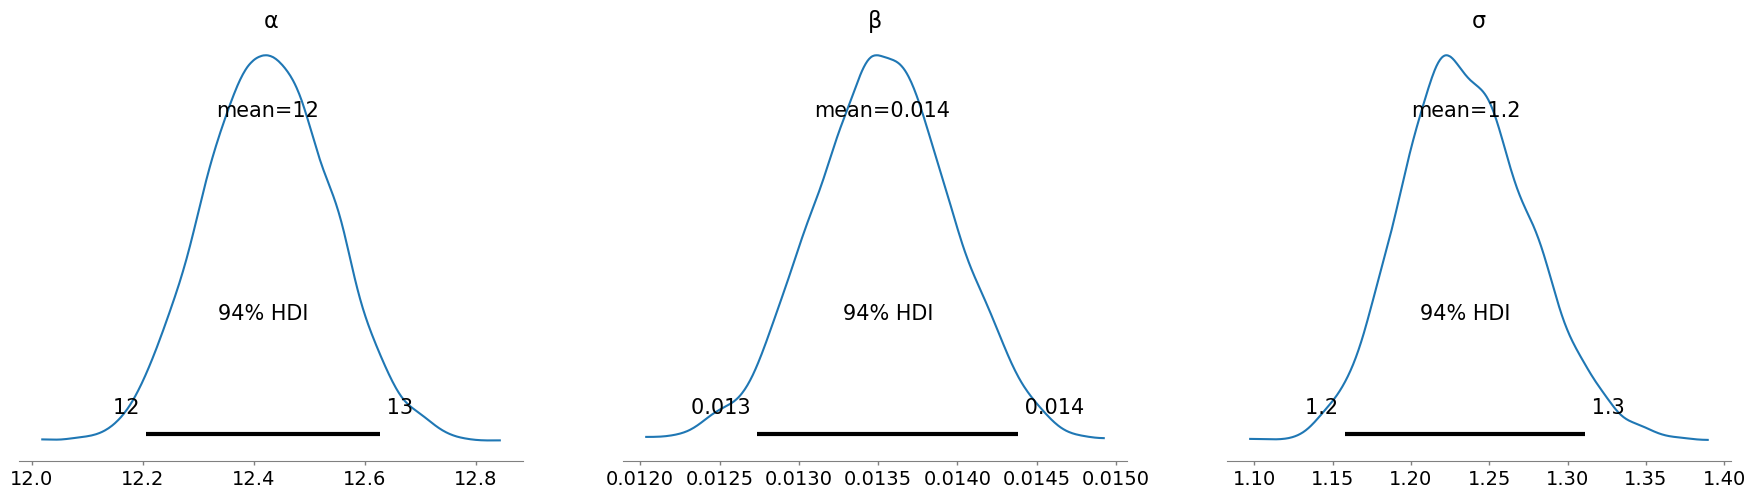

In [15]:
az.plot_posterior(data=unpooled, var_names=prior_vars, group='posterior');

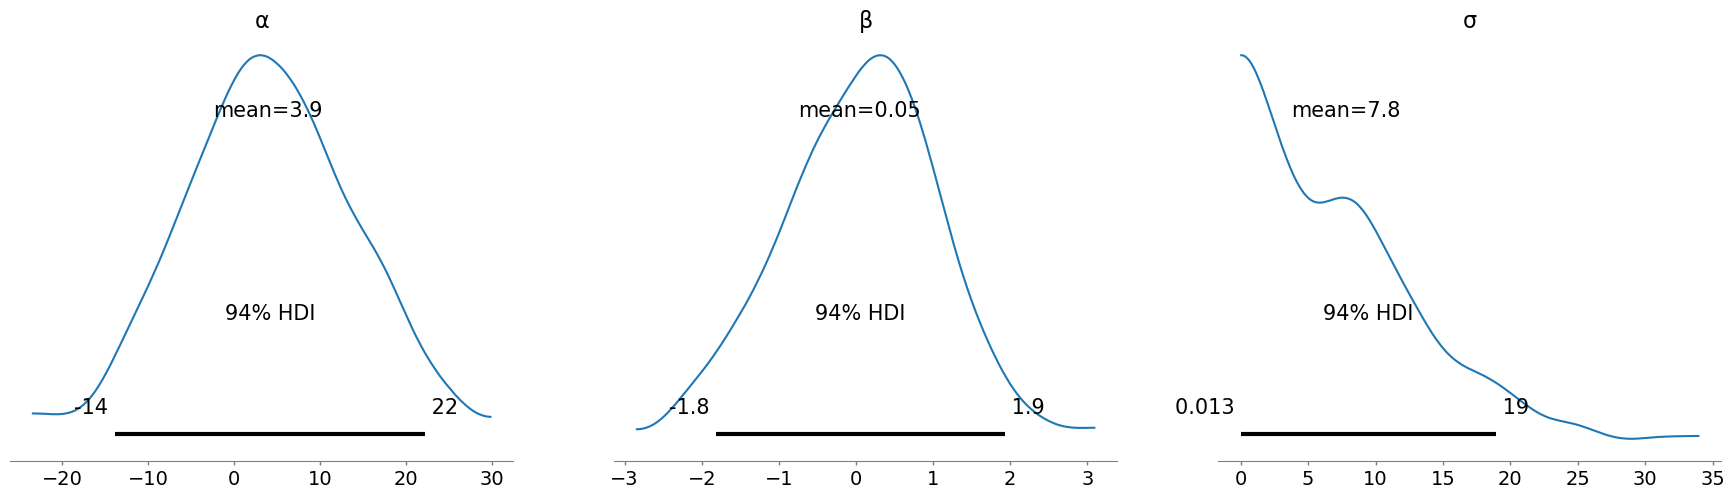

In [16]:
az.plot_posterior(data=unpooled, var_names=prior_vars, group='prior');

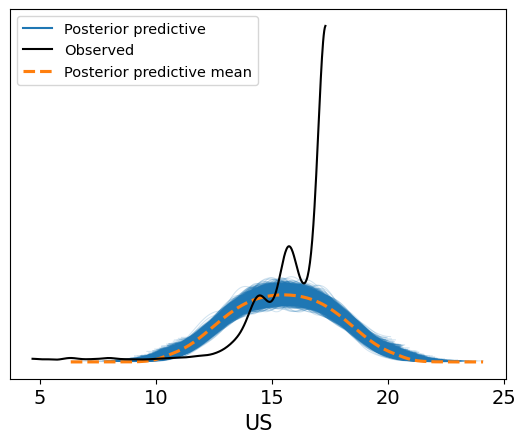

In [17]:
az.plot_ppc(data=unpooled, group='posterior');

In [18]:
# pm.find_MAP(model=unpooled_model)

In [19]:
mean_priors = az.summary(unpooled).filter(items=prior_vars, axis=0)['mean']
y_fitted = mean_priors['α'] + mean_priors['β']*x

mean_priors

α    12.425
β     0.014
σ     1.235
Name: mean, dtype: float64

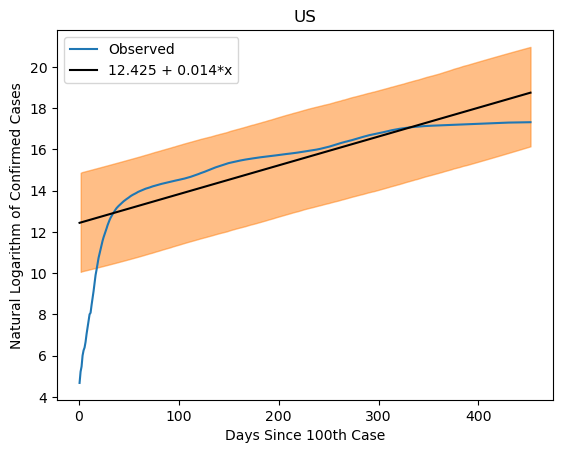

In [20]:
ci = 0.95


az.plot_hdi(x=x, y=unpooled.posterior_predictive[country], hdi_prob=ci)#, plot_kwargs={'label': f'Predictions ({ci})'});
# az.plot_hpd(x=x, y=unpooled.posterior['μ'], color='C2', credible_interval=ci)#, plot_kwargs={'label': f'Expectation ({ci})'});
plt.plot(x, y, label='Observed');
plt.plot(x, y_fitted, label=f"{mean_priors['α']} + {mean_priors['β']}*x", color='k');

plt.xlabel(f'Days Since {threshold}th Case')
plt.ylabel('Natural Logarithm of Confirmed Cases')
plt.title(country)
plt.legend()
plt.show()
plt.close()

In [21]:
az.r2_score(y_true=y, y_pred=unpooled.posterior_predictive[country].data.reshape(-1, y.shape[0]))

r2        0.604197
r2_std    0.019207
dtype: float64

In [22]:
# az.plot_dist(unpooled.log_likelihood[country]);
# az.plot_dist(unpooled.prior_predictive[country]);

In [23]:
## Mean of predicted values

y_fitted = unpooled.posterior_predictive[country].data.reshape(-1, y.shape[0]).mean(axis=0)
print(f"r2_score = {round(r2_score(y, y_fitted), 2)}")
print(f"mean_squared_error = {round(mean_squared_error(y, y_fitted), 2)}")

r2_score = 0.67
mean_squared_error = 1.51


In [24]:
## Mean of expected values

y_fitted = unpooled.posterior['μ'].data.reshape(-1, y.shape[0]).mean(axis=0)
print(f"r2_score = {round(r2_score(y, y_fitted), 2)}")
print(f"mean_squared_error = {round(mean_squared_error(y, y_fitted), 2)}")

r2_score = 0.67
mean_squared_error = 1.51


#### Finding appropriate start date for all data
For both `pooled` and `hierarchical`

In [25]:
# Data for all counties needs to be in similar dimensions.

cumulative_threshold = 1e4 # to select countries
threshold = 100 # to select start_date

high_confirmed_df = confirmed_df[confirmed_df.iloc[:, -1] > cumulative_threshold]
high_confirmed_df = high_confirmed_df.where(cond=lambda x: x > threshold, other=np.nan) # or -1

In [26]:
# Dropping for now
high_confirmed_df = high_confirmed_df.drop(index=['China', 'Korea, South'])

In [27]:
majority = high_confirmed_df.shape[0]/2

high_confirmed_df.isna().sum().iplot(hline=majority,
                                     xTitle='Date', yTitle=f'Countries below {threshold} cases', 
                                     title='Threshold Cases for Highly Infected Countries');

In [28]:
cross_over_date = (high_confirmed_df.isna().sum() < majority).idxmax()
cross_over_date

'3/23/20'

#### Preparing data 
For both `pooled` and `hierarchical`

In [29]:
thresholded_high_confirmed_df = high_confirmed_df.iloc[:, high_confirmed_df.columns.to_list().index(cross_over_date):]
thresholded_high_confirmed_df = thresholded_high_confirmed_df.dropna(how='any', axis=0)
thresholded_high_confirmed_df = thresholded_high_confirmed_df.applymap(np.log)

print(thresholded_high_confirmed_df.shape)

(75, 433)


/var/folders/5x/vz4_nh_d6f5ds1c71xs4q_n0qqgwj_/T/ipykernel_65526/1674293464.py:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [30]:
n_countries = thresholded_high_confirmed_df.shape[0]
date_points = thresholded_high_confirmed_df.shape[1]
idx = np.repeat(a=np.arange(n_countries), repeats=date_points)

### Pooled Model

Shared/ grouped priors between all countries

In [31]:
x = np.arange(1, date_points + 1)
XX = np.stack([x]*n_countries, axis=0)

YY = thresholded_high_confirmed_df.values

print(XX.shape, YY.shape)

(75, 433) (75, 433)


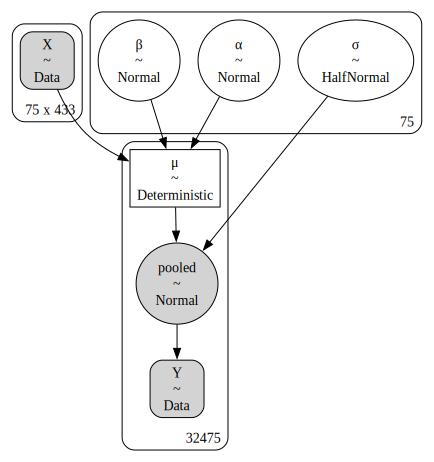

In [32]:
def split_and_pack(labels, data, axis=2):
    '''
    Helper function to unpack values from a vectorised output
    '''
    splits = np.split(ary=data, axis=axis, indices_or_sections=len(labels))
    d = dict(zip(labels, data))
    return d
    

with pm.Model() as pooled_model:

    
    X = pm.Data(name='X', value=XX)
    Y = pm.Data(name='Y', value=YY.flatten())
    
    # priors
    α = pm.Normal(name='α', mu=int(np.log(threshold)), sigma=10, shape=n_countries)
    β = pm.Normal(name='β', sigma=5, shape=n_countries)
    
    # error
    σ = pm.HalfNormal(name='σ', sigma=10, shape=n_countries)
    
    # expected value
    
    μ = pm.Deterministic(name='μ', var= (α + β*X.T).T.flatten())
    
    # liklihood == 'prior_predictive'
    pm.Normal(name='pooled', mu=μ, sigma=σ[idx], observed=Y)
    
gv = pm.model_to_graphviz(pooled_model)
gv.format = 'png'
gv.render(filename='pooled_model.png')
gv

In [33]:
with pooled_model:
    
    # sampling liklihood
    prior = pm.sample_prior_predictive()
    
    # posterior
    trace = pm.sample()
    
    # predictions == 'posterior_predictive'
    pred = pm.sample_posterior_predictive(trace)

Sampling: [pooled, α, β, σ]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.
Sampling: [pooled]


Output()

In [34]:
# pooled = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=pred, model=pooled_model)
pooled = custom_from_pymc3(trace, prior, pred)
prior_vars = ['α', 'β', 'σ']
pooled

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [35]:
# pm.find_MAP(model=pooled_model)

In [36]:
pooled.posterior['α'].shape # chains x samples x n_countries

(4, 1000, 75)

In [37]:
summary_df = az.summary(pooled) 
summary_df.to_csv('pooled_summary.csv')

In [38]:
countries = thresholded_high_confirmed_df.index.to_list()
means = {var : split_and_pack(data=summary_df.filter(like=var, axis=0)['mean'], labels=countries, axis=0) for var in prior_vars }
means_df = pd.DataFrame(means)

means_df

/Users/22337766/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.



α      β      σ
Albania                  6.286  0.015  0.427
Algeria                  8.401  0.010  0.629
Andorra                  5.971  0.009  0.312
Argentina                8.949  0.017  1.015
Armenia                  8.172  0.012  0.752
Australia                8.880  0.004  0.349
Austria                  8.859  0.012  0.397
Bahrain                  8.472  0.010  0.732
Belgium                 10.070  0.010  0.397
Bosnia and Herzegovina   7.131  0.014  0.528
Brazil                  11.890  0.013  1.048
Bulgaria                 6.837  0.017  0.492
Canada                  10.286  0.010  0.381
Chile                   10.509  0.010  0.869
Colombia                 9.388  0.016  1.039
Costa Rica               6.877  0.016  0.883
Croatia                  6.780  0.016  0.500
Cyprus                   5.606  0.014  0.408
Czechia                  8.028  0.017  0.528
Denmark                  8.405  0.011  0.311
Dominican Republic       9.012  0.010  0.698
Ecuador                  9.749  0.009  0.558
Egypt                    9.196  0.009  0.839
Estonia                  6.258  0.013  0.428
Finland                  7.832  0.009  0.248
France                  11.197  0.011  0.345
Germany                 11.224  0.010  0.295
Greece                   7.011  0.015  0.370
Hungary                  6.696  0.018  0.577
India                   10.987  0.017  1.237
Indonesia                9.145  0.015  0.632
Iran                    11.249  0.009  0.213
Iraq                     8.521  0.016  1.058
Ireland                  9.094  0.009  0.353
Israel                   9.319  0.012  0.476
Italy                   11.461  0.010  0.331
Japan                    8.837  0.012  0.335
Jordan                   5.118  0.023  0.794
Kuwait                   8.816  0.011  0.919
Latvia                   5.523  0.016  0.528
Lebanon                  6.179  0.019  0.566
Lithuania                5.970  0.017  0.604
Luxembourg               7.657  0.009  0.285
Malaysia                 7.689  0.013  0.398
Malta                    5.472  0.013  0.309
Mexico                  10.193  0.013  0.990
Moldova                  8.046  0.012  0.630
Morocco                  8.074  0.015  0.749
Netherlands              9.744  0.012  0.351
North Macedonia          7.061  0.013  0.492
Norway                   8.303  0.008  0.206
Pakistan                10.276  0.010  0.838
Panama                   8.845  0.012  0.657
Peru                    10.648  0.011  1.014
Philippines              9.176  0.013  0.720
Poland                   8.690  0.017  0.506
Portugal                 9.402  0.011  0.338
Qatar                    9.804  0.007  0.872
Romania                  8.900  0.014  0.488
Russia                  11.337  0.012  0.975
Saudi Arabia            10.465  0.008  0.960
Serbia                   8.084  0.014  0.471
Singapore                9.611  0.005  0.745
Slovakia                 5.995  0.019  0.605
Slovenia                 6.136  0.017  0.598
South Africa             9.696  0.014  1.120
Spain                   11.701  0.009  0.254
Sweden                   9.521  0.011  0.350
Switzerland              9.519  0.010  0.396
Thailand                 7.048  0.008  0.514
Turkey                  10.702  0.012  0.498
US                      13.577  0.010  0.452
United Arab Emirates     9.082  0.011  0.641
United Kingdom          11.351  0.011  0.369
Uruguay                  5.186  0.016  0.454

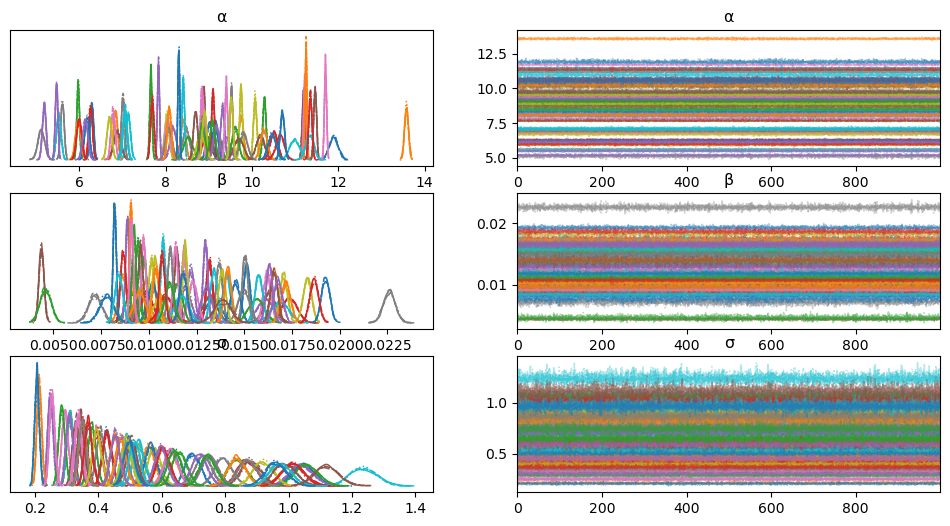

In [39]:
az.plot_trace(data=pooled, var_names=prior_vars);

In [40]:
# # Plotting posterior will give a combined view of all countries
# az.plot_posterior(data=pooled, var_names=prior_vars, group='posterior');

In [41]:
# az.plot_posterior(data=pooled, var_names=prior_vars, group='prior');

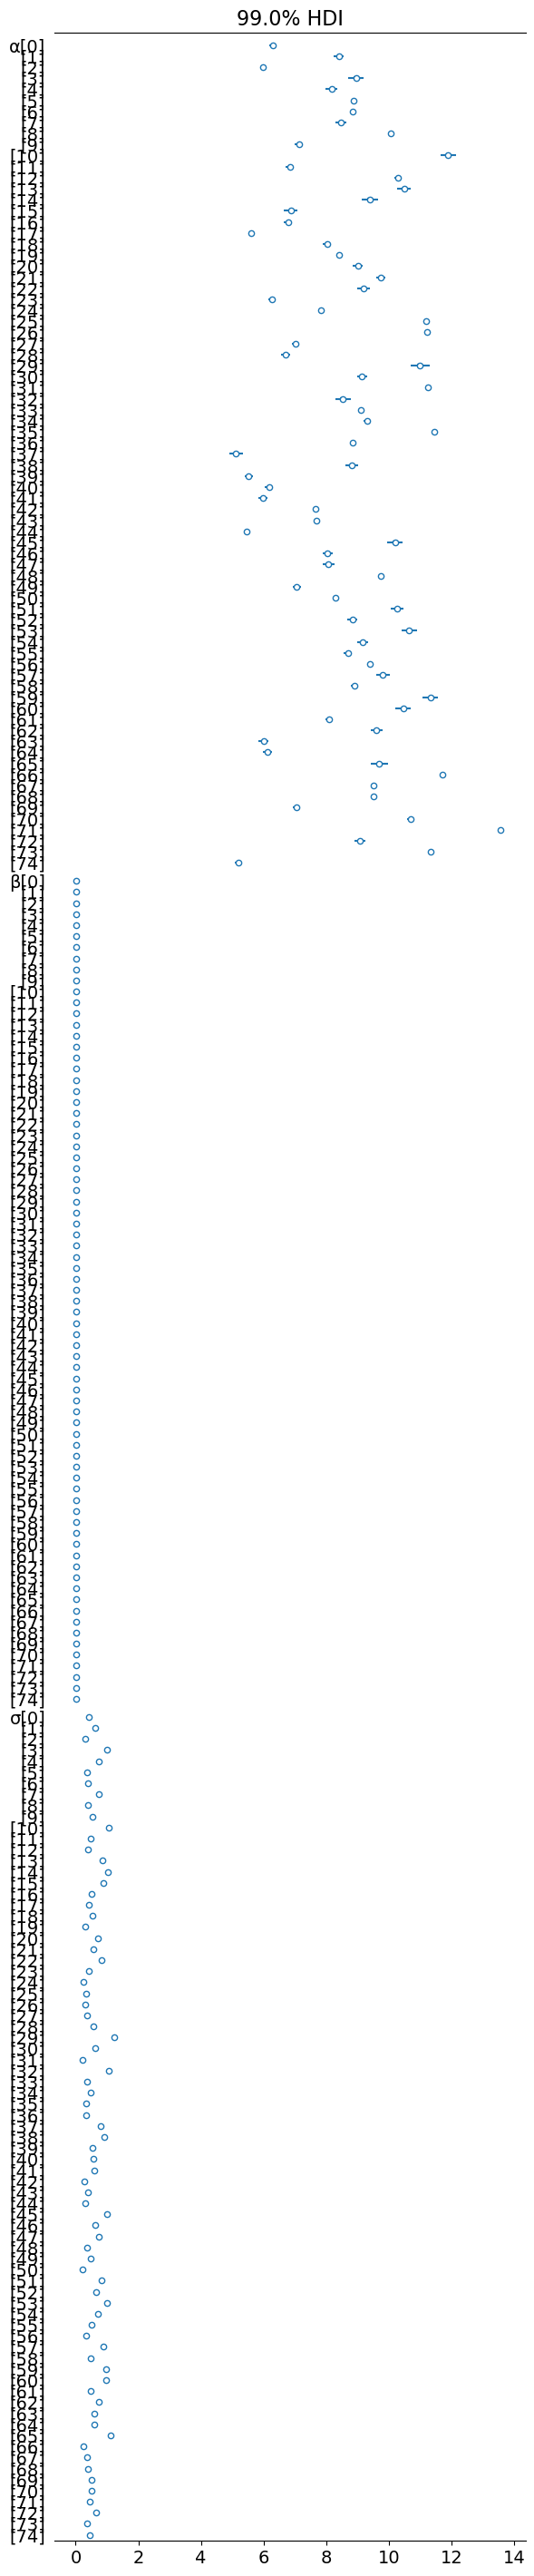

In [42]:
az.plot_forest(data=pooled, var_names=prior_vars, combined=True, hdi_prob=0.99);
plt.tight_layout()

In [43]:
# posterior_predictive = split_and_pack(data=pooled.posterior_predictive['pooled'].data, labels=countries, axis=2) # not working??
posterior_predictive = dict(zip(countries, np.split(ary=pooled.posterior_predictive['pooled'].data, axis=2, indices_or_sections=len(countries))))

X_countrywise = split_and_pack(data=pooled.constant_data['X'].data, labels=countries, axis=0)

# Y_countrywise = split_and_pack(data=pooled.constant_data['Y'].data, labels=countries, axis=0)
Y_countrywise = dict(zip(countries, np.split(ary=pooled.constant_data['Y'].data, axis=0, indices_or_sections=len(countries))))

In [72]:
@interact(country=countries)
def plot_countrywise_posterior(country):
    
    ci = 0.95
    
    plt.figure(figsize=(15, 10))

    az.plot_hdi(x=x, y=posterior_predictive[country], hdi_prob=ci);
    plt.plot(X_countrywise[country], Y_countrywise[country], label='Observed');
    
    y_fitted = means_df['α'][country] + means_df['β'][country]*X_countrywise[country]
    
    plt.plot(X_countrywise[country], y_fitted, label=f"{means_df['α'][country]} + {means_df['β'][country]}*x", color='k');

    plt.xlabel(f'Days Since {threshold}th Case')
    plt.ylabel('Natural Logarithm of Confirmed Cases')
    plt.title(country)
    plt.legend()
    plt.show()
    plt.close()
    
    bayesian_r2 = az.r2_score(y_true=Y_countrywise[country], y_pred=posterior_predictive[country].reshape(-1, Y_countrywise[country].shape[0]))
    y_fitted_bayesian = posterior_predictive[country].reshape(-1, Y_countrywise[country].shape[0]).mean(axis=0)
    print(f"Bayesian r2_score = {round(bayesian_r2['r2'], 2)}")
    print(f"Bayesian r2_score std = {round(bayesian_r2['r2_std'], 2)}")
    print('\n')
    print(f"Point(mean) r2_score = {r2_score(Y_countrywise[country], y_fitted_bayesian)}")
    # print(f"Point(mean) r2_score = {round(r2_score(Y_countrywise[country], y_fitted_bayesian), 2)}")
    print(f"Point(mean) mean_squared_error = {mean_squared_error(Y_countrywise[country], y_fitted_bayesian)}")
    # print(f"Point(mean) mean_squared_error = {round(mean_squared_error(Y_countrywise[country], y_fitted_bayesian), 2)}")

interactive(children=(Dropdown(description='country', options=('Albania', 'Algeria', 'Andorra', 'Argentina', '…

### Hierarchical Model

Shared hyper-priors but different priors for all countries

In [66]:
country2idx = {country: i for i, country in enumerate(countries)}
country2idx['US']

71

In [45]:
x = np.arange(1, date_points + 1)
XX = np.stack([x]*n_countries, axis=0)

YY = thresholded_high_confirmed_df.values

print(XX.shape, YY.shape)

(75, 433) (75, 433)


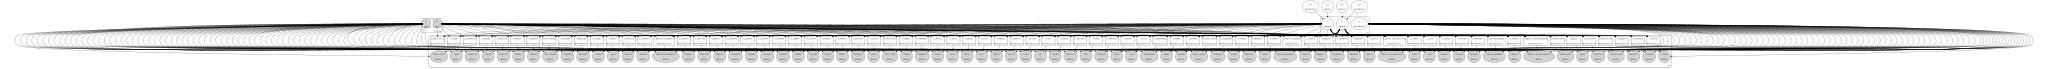

In [46]:
# non-vectorised implementation
'''
All three parameters (mu, sd, observed) have to be of the same shape / broadcasteble
'''

with pm.Model() as hierarchical_model:

    X = pm.Data(name='X', value=XX)
    Y = pm.Data(name='Y', value=YY) # not using it since we will iterate over the dataframe
    
    # hyper-priors
    α_μ = pm.Normal(name='α_μ', mu=int(np.log(threshold)), sigma=10)
    α_σ = pm.HalfNormal(name='α_σ', sigma=10)
    
    β_μ = pm.Normal(name='β_μ', sigma=10)
    β_σ = pm.HalfNormal(name='β_σ', sigma=10)
    
    # priors
    α = pm.Normal(name='α', mu=α_μ, sigma=α_σ, shape=n_countries)
    β = pm.Normal(name='β', mu=β_μ, sigma=β_σ, shape=n_countries)
    
    # error
    σ = pm.HalfNormal(name='σ', sigma=10, shape=n_countries)
    
    # liklihood
    for i, (index, row) in enumerate(thresholded_high_confirmed_df.iterrows()):
        
        μ = pm.Deterministic(name=f'μ_{index}', var= α[i] + β[i]*X[i])
        zeros = np.zeros(shape=(YY.shape[1], ))
        pm.Normal(name=index, mu=μ-Y[i], sigma=σ[i], observed=zeros)  # or observed=row.values
                    
gv = pm.model_to_graphviz(hierarchical_model)
gv.format = 'png'
gv.render(filename='hierarchical_model.png')
gv

In [47]:
with hierarchical_model:
    
    # sampling liklihood
    prior = pm.sample_prior_predictive()
    
    # posterior
    trace = pm.sample()
    
    # predictions == 'posterior_predictive'
    pred = pm.sample_posterior_predictive(trace)

Sampling: [Albania, Algeria, Andorra, Argentina, Armenia, Australia, Austria, Bahrain, Belgium, Bosnia and Herzegovina, Brazil, Bulgaria, Canada, Chile, Colombia, Costa Rica, Croatia, Cyprus, Czechia, Denmark, Dominican Republic, Ecuador, Egypt, Estonia, Finland, France, Germany, Greece, Hungary, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Japan, Jordan, Kuwait, Latvia, Lebanon, Lithuania, Luxembourg, Malaysia, Malta, Mexico, Moldova, Morocco, Netherlands, North Macedonia, Norway, Pakistan, Panama, Peru, Philippines, Poland, Portugal, Qatar, Romania, Russia, Saudi Arabia, Serbia, Singapore, Slovakia, Slovenia, South Africa, Spain, Sweden, Switzerland, Thailand, Turkey, US, United Arab Emirates, United Kingdom, Uruguay, α, α_μ, α_σ, β, β_μ, β_σ, σ]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 158 seconds.
Sampling: [Albania, Algeria, Andorra, Argentina, Armenia, Australia, Austria, Bahrain, Belgium, Bosnia and Herzegovina, Brazil, Bulgaria, Canada, Chile, Colombia, Costa Rica, Croatia, Cyprus, Czechia, Denmark, Dominican Republic, Ecuador, Egypt, Estonia, Finland, France, Germany, Greece, Hungary, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Japan, Jordan, Kuwait, Latvia, Lebanon, Lithuania, Luxembourg, Malaysia, Malta, Mexico, Moldova, Morocco, Netherlands, North Macedonia, Norway, Pakistan, Panama, Peru, Philippines, Poland, Portugal, Qatar, Romania, Russia, Saudi Arabia, Serbia, Singapore, Slovakia, Slovenia, South Africa, Spain, Sweden, Switzerland, Thailand, Turkey, US, United Arab Emirates, United Kingdom, Uruguay]


Output()

In [48]:
# hierarchical = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=pred, model=hierarchical_model)
hierarchical = custom_from_pymc3(trace, prior, pred)
prior_vars = ['α', 'β', 'σ']
hierarchical

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [49]:
# pm.find_MAP(model=hierarchical_model)

In [50]:
hierarchical.posterior['α'].shape # chains x samples x n_countries

(4, 1000, 75)

In [51]:
summary_df = az.summary(hierarchical) 
summary_df.to_csv('hierarchical_summary.csv')

In [52]:
countries = thresholded_high_confirmed_df.index.to_list()
means = {var : split_and_pack(data=summary_df.filter(like=f"{var}[", axis=0)['mean'], labels=countries, axis=0) for var in prior_vars }
means_df = pd.DataFrame(means)

means_df

/Users/22337766/anaconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.



α      β      σ
Albania                  6.288  0.015  0.427
Algeria                  8.398  0.010  0.629
Andorra                  5.971  0.009  0.312
Argentina                8.962  0.017  1.015
Armenia                  8.171  0.012  0.752
Australia                8.878  0.004  0.349
Austria                  8.860  0.012  0.397
Bahrain                  8.470  0.010  0.732
Belgium                 10.069  0.010  0.396
Bosnia and Herzegovina   7.134  0.014  0.528
Brazil                  11.883  0.013  1.047
Bulgaria                 6.842  0.017  0.492
Canada                  10.284  0.010  0.381
Chile                   10.501  0.010  0.870
Colombia                 9.397  0.016  1.040
Costa Rica               6.888  0.016  0.883
Croatia                  6.783  0.016  0.500
Cyprus                   5.609  0.014  0.408
Czechia                  8.031  0.017  0.528
Denmark                  8.405  0.011  0.311
Dominican Republic       9.008  0.010  0.698
Ecuador                  9.743  0.009  0.559
Egypt                    9.190  0.009  0.839
Estonia                  6.261  0.013  0.428
Finland                  7.832  0.009  0.248
France                  11.197  0.011  0.345
Germany                 11.222  0.010  0.295
Greece                   7.012  0.015  0.370
Hungary                  6.703  0.018  0.577
India                   10.996  0.017  1.237
Indonesia                9.147  0.015  0.632
Iran                    11.249  0.009  0.213
Iraq                     8.530  0.016  1.058
Ireland                  9.093  0.009  0.353
Israel                   9.317  0.012  0.476
Italy                   11.459  0.010  0.331
Japan                    8.837  0.012  0.335
Jordan                   5.142  0.023  0.794
Kuwait                   8.812  0.011  0.919
Latvia                   5.528  0.016  0.527
Lebanon                  6.187  0.019  0.566
Lithuania                5.975  0.017  0.603
Luxembourg               7.656  0.009  0.285
Malaysia                 7.691  0.013  0.398
Malta                    5.473  0.013  0.309
Mexico                  10.191  0.013  0.991
Moldova                  8.046  0.012  0.630
Morocco                  8.078  0.015  0.749
Netherlands              9.743  0.012  0.350
North Macedonia          7.062  0.013  0.493
Norway                   8.302  0.008  0.206
Pakistan                10.270  0.010  0.838
Panama                   8.843  0.012  0.657
Peru                    10.642  0.011  1.014
Philippines              9.178  0.013  0.720
Poland                   8.692  0.017  0.506
Portugal                 9.401  0.011  0.338
Qatar                    9.790  0.007  0.871
Romania                  8.900  0.014  0.488
Russia                  11.329  0.012  0.975
Saudi Arabia            10.449  0.008  0.960
Serbia                   8.085  0.014  0.471
Singapore                9.599  0.005  0.744
Slovakia                 6.006  0.019  0.605
Slovenia                 6.143  0.017  0.598
South Africa             9.696  0.014  1.121
Spain                   11.700  0.009  0.254
Sweden                   9.520  0.011  0.350
Switzerland              9.519  0.010  0.396
Thailand                 7.046  0.008  0.515
Turkey                  10.702  0.012  0.497
US                      13.574  0.010  0.453
United Arab Emirates     9.080  0.011  0.642
United Kingdom          11.349  0.011  0.369
Uruguay                  5.190  0.016  0.454

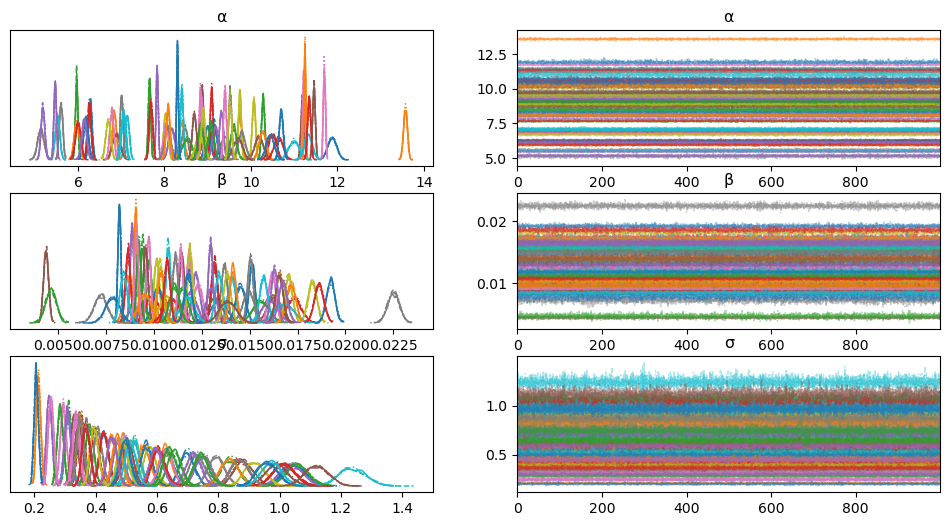

In [53]:
az.plot_trace(data=hierarchical, var_names=prior_vars);

In [54]:
# # Plotting posterior will give a combined view of all countries
# az.plot_posterior(data=hierarchical, var_names=prior_vars, group='posterior');

In [55]:
# az.plot_posterior(data=hierarchical, var_names=prior_vars, group='prior');

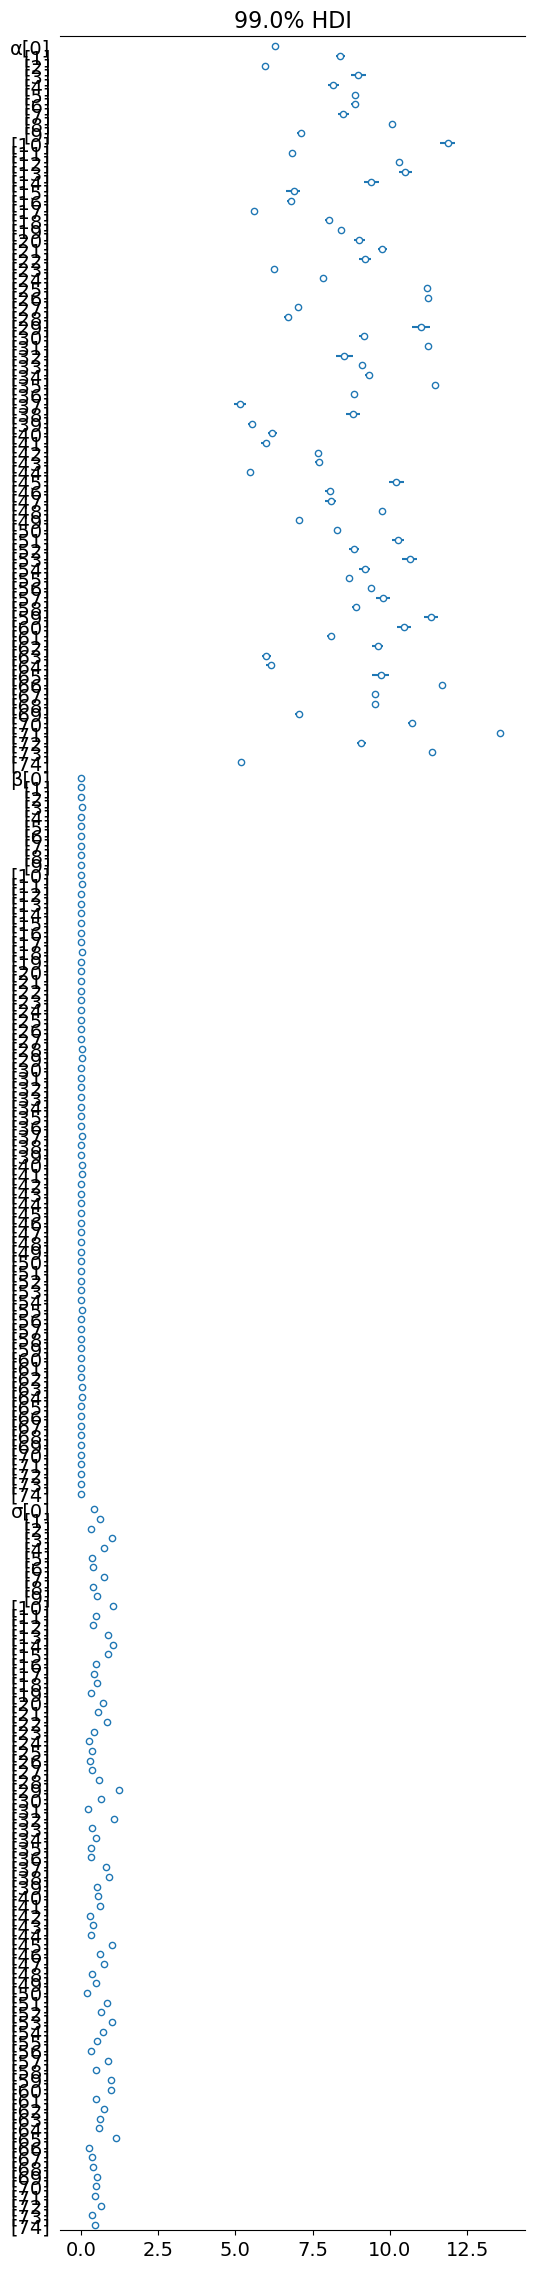

In [56]:
az.plot_forest(data=hierarchical, var_names=prior_vars, combined=True, hdi_prob=0.99);

In [57]:
X_countrywise = split_and_pack(data=hierarchical.constant_data['X'].data, labels=countries, axis=0)
Y_countrywise = split_and_pack(data=hierarchical.constant_data['Y'].data, labels=countries, axis=0)

In [68]:
hierarchical.posterior_predictive[country].shape, YY.shape

((4, 1000, 433), (75, 433))

In [67]:
hierarchical.posterior_predictive[country] + YY[country2idx[country]]

<xarray.DataArray 'US' (chain: 4, draw: 1000, US_dim_2: 433)> Size: 14MB
array([[[13.43868809, 12.9588749 , 13.67112765, ..., 17.44967794,
         18.45198762, 18.10052922],
        [13.85025804, 13.16125535, 13.62530336, ..., 18.5431948 ,
         18.40420037, 17.58033962],
        [13.73224485, 13.11936271, 13.88044597, ..., 17.90273364,
         17.94693373, 18.10428075],
        ...,
        [13.2190043 , 13.27657325, 13.94322844, ..., 18.57068926,
         17.80514209, 18.14877724],
        [14.03872908, 13.66086888, 13.81545826, ..., 17.43294207,
         17.96714882, 18.01098418],
        [14.36020378, 13.37668044, 13.70990765, ..., 18.00725549,
         17.09163917, 18.35882085]],

       [[13.67290543, 13.0924739 , 12.92995788, ..., 17.55671035,
         18.13087176, 17.55599238],
        [12.68059139, 13.73808416, 13.60040771, ..., 17.68110921,
         17.83843739, 18.52617928],
        [13.74095978, 13.89397769, 13.17467398, ..., 18.54817301,
         17.92856076, 17.59216545],
...
        [13.72568679, 13.7645812 , 14.04924287, ..., 18.18701486,
         18.0269913 , 17.7471801 ],
        [13.26423011, 13.91954101, 14.5015699 , ..., 17.18920596,
         18.93609427, 17.81462841],
        [13.39590818, 13.79339428, 13.75717578, ..., 18.57607835,
         17.48601474, 18.35033667]],

       [[13.22966512, 13.31777913, 14.12817323, ..., 17.96248215,
         17.84198711, 18.05885164],
        [13.66222511, 13.64419972, 14.7634544 , ..., 18.86485232,
         17.79027268, 17.61238906],
        [14.20216286, 12.72090629, 12.78809387, ..., 18.23547609,
         17.65730873, 18.66365476],
        ...,
        [12.96148126, 13.04767378, 13.67370199, ..., 17.76859276,
         17.79586139, 18.31563019],
        [15.06835694, 14.74212133, 13.93024826, ..., 17.14351052,
         18.70189106, 17.95402507],
        [13.29859502, 13.28402195, 13.68416291, ..., 18.154185  ,
         18.21119663, 18.33553031]]])
Coordinates:
  * chain     (chain) int64 32B 0 1 2 3
  * draw      (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * US_dim_2  (US_dim_2) int64 3kB 0 1 2 3 4 5 6 ... 426 427 428 429 430 431 432

In [71]:
@interact(country=countries)
def plot_countrywise_posterior(country):
    
    ci = 0.95
    
    plt.figure(figsize=(15, 10))

    preds = hierarchical.posterior_predictive[country] + YY[country2idx[country]]
    az.plot_hdi(x=X_countrywise[country], y=preds, hdi_prob=ci);
    plt.plot(X_countrywise[country], Y_countrywise[country], label='Observed');
    
    y_fitted = means_df['α'][country] + means_df['β'][country]*X_countrywise[country]
    
    plt.plot(X_countrywise[country], y_fitted, label=f"{means_df['α'][country]} + {means_df['β'][country]}*x", color='k');

    plt.xlabel(f'Days Since {threshold}th Case')
    plt.ylabel('Natural Logarithm of Confirmed Cases')
    plt.title(country)
    plt.legend()
    plt.show()
    plt.close()
    
    bayesian_r2 = az.r2_score(y_true=Y_countrywise[country], y_pred=preds.data.reshape(-1, Y_countrywise[country].shape[0]))
    y_fitted_bayesian = preds.data.reshape(-1, Y_countrywise[country].shape[0]).mean(axis=0)
    print(f"Bayesian r2_score = {round(bayesian_r2['r2'], 2)}")
    print(f"Bayesian r2_score std = {round(bayesian_r2['r2_std'], 2)}")
    print('\n')
    print(f"Point(mean) r2_score = {r2_score(Y_countrywise[country], y_fitted_bayesian)}")
    # print(f"Point(mean) r2_score = {round(r2_score(Y_countrywise[country], y_fitted_bayesian), 2)}")
    print(f"Point(mean) mean_squared_error = {mean_squared_error(Y_countrywise[country], y_fitted_bayesian)}")
    # print(f"Point(mean) mean_squared_error = {round(mean_squared_error(Y_countrywise[country], y_fitted_bayesian), 2)}")

interactive(children=(Dropdown(description='country', options=('Albania', 'Algeria', 'Andorra', 'Argentina', '…

## Comparison

In [59]:
datasets = {'unpooled' : unpooled,
           'pooled' : pooled,
           'hierarchical': hierarchical} 

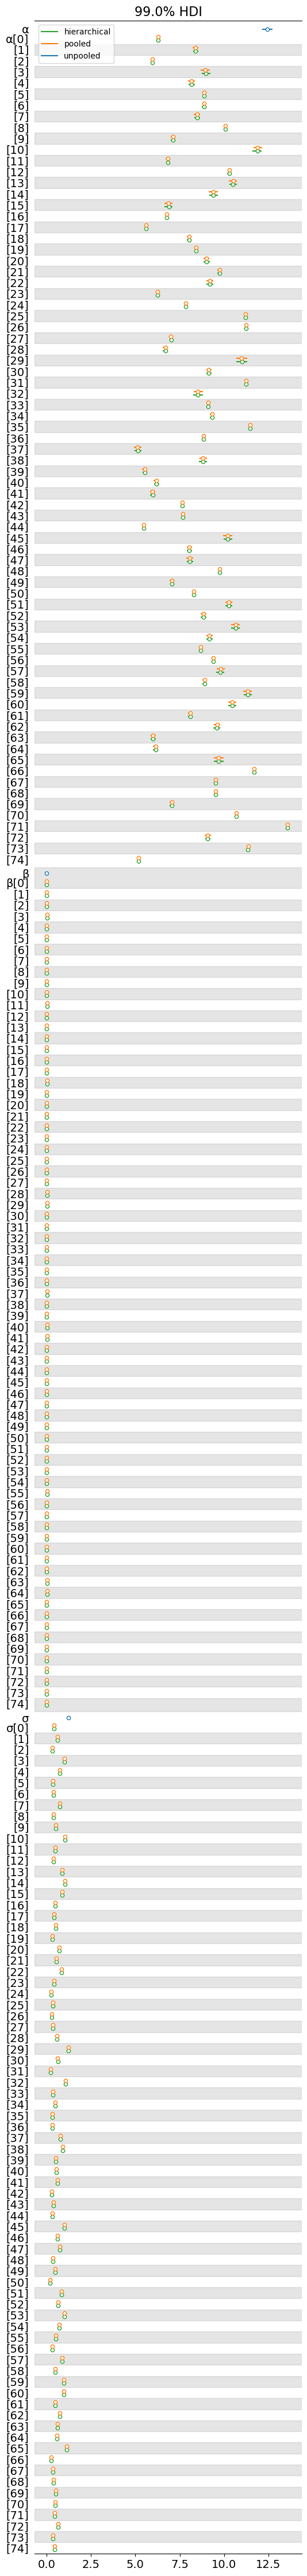

In [60]:
az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), var_names=prior_vars, hdi_prob=0.99, combined=True);
plt.savefig('comparison.png')

## To-Do:

1. Implement a different model for China and S. Korea (preferably logistic growth model).
2. Find the effect of intervention policy and try to determine the intervention date from the data.
3. Comment your suggestions 😁.